# Persistent Homology for Market Analysis

### Import modules

In [2]:
import yfinance as yf
import numpy as np

from ripser import Rips
import persim
import pandas as pd

import matplotlib.pyplot as plt

# sorry about this
import warnings
warnings.filterwarnings("ignore")

### Get data

In [3]:
# define index names: ^GSPC = S&P 500, ^DJI = DOW Jones, ^IXIC=NASDAQ, ^RUT = Russell 2000
index_names = list(pd.read_csv("sp500.csv")["Symbol"])

# define date range
start_date_string = "2018-01-01"
end_date_string = "2025-09-01"

In [4]:
# pull data from yahoo finance
raw_data = yf.download(index_names, start=start_date_string, end=end_date_string, auto_adjust=False)

[**********************62%*****                  ]  314 of 503 completedHTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: HES"}}}
[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-09-01)')
['BRK.B', 'HES', 'ANSS']: YFTzMissingError('possibly delisted; no timezone found')


In [5]:
# keep only adjusted closing prices
df_close = raw_data['Adj Close'].dropna(axis='columns')

### Data prep
Data preparation follows procedure described in: https://arxiv.org/abs/1703.04385

In [6]:
# define array of adjusted closing prices
P = df_close.to_numpy()
# define array of log-returns defined as the log of the ratio between closing values of two subsequent days
r = np.log(np.divide(P[1:],P[:len(P)-1]))

### Persistent homology

In [7]:
r.shape

(1925, 476)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


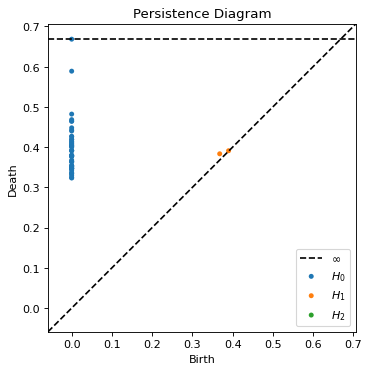

In [8]:
# Instantiate Vietoris-Rips solver
rips = Rips(maxdim = 2)

dgm = rips.fit_transform(r[0:50])

plt.figure(figsize=(5, 5), dpi=80)
plt.rcParams.update({'font.size': 10})
persim.plot_diagrams(dgm, title="Persistence Diagram")

plt.savefig("homology_example_persistence-diagram.png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')

In [9]:
import numpy as np

def betti_numbers_at_scale(diagrams, eps):
    bettis = []
    for dgm in diagrams:
        alive = np.sum((dgm[:, 0] <= eps) & (dgm[:, 1] > eps))
        bettis.append(alive)
    return bettis


In [27]:
dic = {}

# Instantiate Vietoris-Rips solver
rips = Rips(maxdim = 2)

# some parameters
w = 20 # time window size
n = len(raw_data)-(2*w)+1 # number of time segments
wasserstein_dists = np.zeros((n,1)) # initialize array for wasserstein distances

dates = df_close.index[1:] # exclude the first day bc what happens in variable r is log returns

# compute wasserstein distances between persistence diagrams for subsequent time windows
for i in range(n):
    # Compute persistence diagrams for adjacent time windows
    dgm1 = rips.fit_transform(r[i:i+w])
    dgm2 = rips.fit_transform(r[i+w+1:i+(2*w)+1])

    # Compute wasserstein distance between diagrams
    res = persim.wasserstein(dgm1[0], dgm2[0], matching=False)
    res = res.item()
    
    bettis1 = betti_numbers_at_scale(dgm1, eps=0.5)
    bettis2 = betti_numbers_at_scale(dgm2, eps=0.5)
    
    diff_sum_bettis = 0
    for betti_index in range(len(bettis2)):
        diff_sum_bettis += abs(bettis2[betti_index] - bettis1[betti_index]) ** 2
    diff_sum_bettis = (diff_sum_bettis) ** 1/2
    
    wasserstein_dists[i] = res
    idx = i+(2*w) - 2
    date = str(dates[idx])
    dic[date] = {
        'wasserstein_distance': res,
        'betti_numbers': bettis2,
        "lp2_distance": diff_sum_bettis
    }

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [ ]:
a = pd.read_csv("sp500_data.csv")

a

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Columns: 2520 entries, Ticker to WMT.4
dtypes: object(2520)
memory usage: 37.1+ MB
None
       Ticker                 NWS               NWS.1               NWS.2  \
0       Price                Open                High                 Low   
1        Date                 NaN                 NaN                 NaN   
2  2018-01-02  15.250454854126517   15.43364420402923  15.204658390162395   
3  2018-01-03  15.387846014010742  15.479440689086914  15.342049549984216   
4  2018-01-04  15.479439981791323   15.64431003999047   15.38784531090035   
5  2018-01-05  15.754225730895996  15.937413345845856  15.479441687936358   
6  2018-01-08  15.708427516891106  15.800022197877652  15.571036368922904   
7  2018-01-09  15.800023078918457  15.891617765012505  15.708428392824409   
8  2018-01-10  15.754226599403212   15.80002306890956  15.662631913367187   
9  2018-01-11  15.754224680394069  16.120601632886768  15.7542246803

In [29]:
dic_df = pd.DataFrame([
    {
        'date': date,
        'wasserstein_distance': values['wasserstein_distance'],
        'beta0': values['betti_numbers'][0] if len(values['betti_numbers']) > 0 else None,
        'beta1': values['betti_numbers'][1] if len(values['betti_numbers']) > 1 else None,
        'beta2': values['betti_numbers'][2] if len(values['betti_numbers']) > 2 else None,
        "lp2_distance": values['lp2_distance']
    }
    for date, values in dic.items()
])

# Save to CSV
dic_df.to_csv("tda_features.csv", index=False)


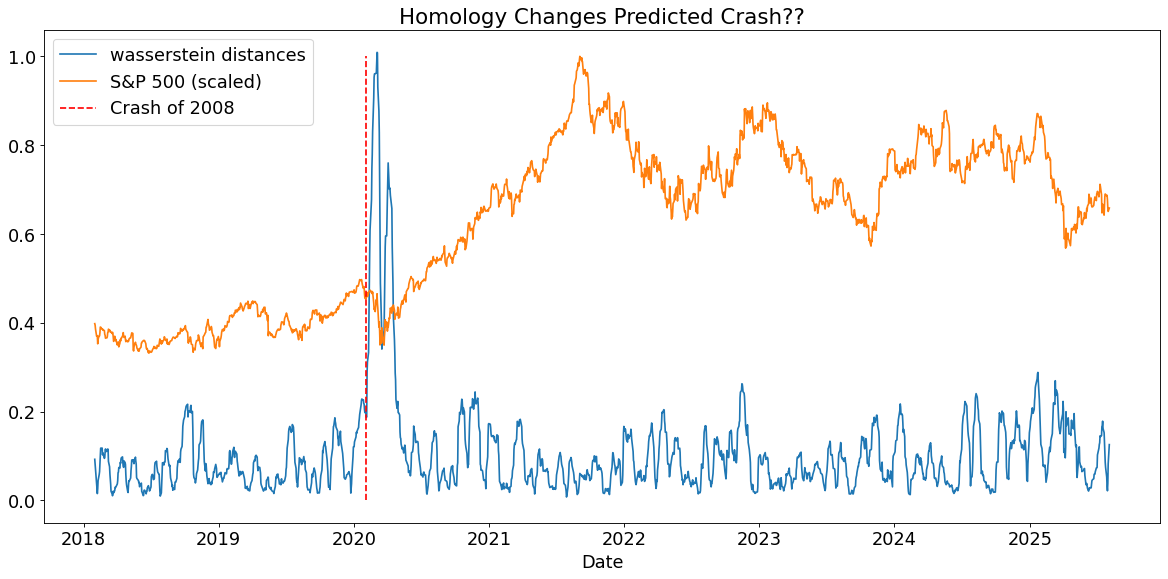

In [12]:
plt.figure(figsize=(18, 8), dpi=80)
plt.rcParams.update({'font.size': 16})

plt.plot(raw_data.index[w:n+w], wasserstein_dists/15)
plt.plot(raw_data.index[w:n+w], df_close.iloc[w:n+w,0]/max(df_close.iloc[w:n+w,0]))

# Move the red line to the 2008 crisis
# Find the index corresponding to the 2008 crisis (e.g., September 15, 2008, Lehman Brothers bankruptcy)
crisis_date = '2008-09-15'
if crisis_date in raw_data.index:
    crisis_idx = raw_data.index.get_loc(crisis_date)
else:
    # If exact date not found, find the closest date
    crisis_idx = raw_data.index.get_indexer([crisis_date], method='nearest')[0]

# The plot uses raw_data.index[w:n+w], so adjust for window offset
plot_idx = crisis_idx
if plot_idx < w or plot_idx >= n + w:
    # If the index is out of plotting range, just use the closest in-range value
    plot_idx = min(max(w, plot_idx), n + w - 1)

crisis_plot_date = raw_data.index[525]
plt.plot([crisis_plot_date, crisis_plot_date], [0, 1], 'r--')

plt.legend(['wasserstein distances', 'S&P 500 (scaled)', 'Crash of 2008'])
plt.xlabel('Date')
plt.title('Homology Changes Predicted Crash??')

plt.savefig("homology_example_Homology-Changes-Predicted-Crash??.png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0.1,
        facecolor='white', edgecolor='auto')

In [ ]:
# Check how many Betti numbers you have
print("Number of Betti numbers:", len(dgm))
print("Betti numbers at different scales:")

# Check Betti numbers at different epsilon values
for eps in [0.1, 0.5, 1.0, 2.0]:
    bettis = betti_numbers_at_scale(dgm, eps)
    print(f"At scale ε={eps}: β₀={bettis[0]}, β₁={bettis[1]}, β₂={bettis[2]}")


In [ ]:
# Modified code for 7 Betti numbers (β₀ through β₆)
# Change maxdim from 2 to 6
rips_7d = Rips(maxdim=6)

# Test with a small subset first to see the computational impact
dgm_7d = rips_7d.fit_transform(r[0:20])  # Using smaller window for testing

print("Number of persistence diagrams:", len(dgm_7d))
print("Dimensions available:", [i for i in range(len(dgm_7d))])

# Updated function to handle 7 Betti numbers
def betti_numbers_at_scale_7d(diagrams, eps):
    bettis = []
    for dgm in diagrams:
        alive = np.sum((dgm[:, 0] <= eps) & (dgm[:, 1] > eps))
        bettis.append(alive)
    return bettis

# Check Betti numbers at different scales
for eps in [0.1, 0.5, 1.0]:
    bettis = betti_numbers_at_scale_7d(dgm_7d, eps)
    print(f"At scale ε={eps}: {bettis}")
    print(f"  β₀={bettis[0]}, β₁={bettis[1]}, β₂={bettis[2]}, β₃={bettis[3]}, β₄={bettis[4]}, β₅={bettis[5]}, β₆={bettis[6]}")


In [ ]:
# Modified main analysis for 7 Betti numbers
dic_7d = {}

# Instantiate Vietoris-Rips solver with maxdim=6
rips_7d_main = Rips(maxdim=6)

# Parameters
w = 20  # time window size
n = len(raw_data)-(2*w)+1  # number of time segments
wasserstein_dists_7d = np.zeros((n,1))

dates = df_close.index[1:]

print("Computing persistence diagrams with 7 Betti numbers...")
print("This will be computationally intensive!")

# Compute persistence diagrams for subsequent time windows
for i in range(min(10, n)):  # Limiting to first 10 iterations for testing
    print(f"Processing window {i+1}/{min(10, n)}")
    
    # Compute persistence diagrams for adjacent time windows
    dgm1 = rips_7d_main.fit_transform(r[i:i+w])
    dgm2 = rips_7d_main.fit_transform(r[i+w+1:i+(2*w)+1])

    # Compute wasserstein distance between diagrams (using 0-dimensional features)
    res = persim.wasserstein(dgm1[0], dgm2[0], matching=False)
    res = res.item()
    
    # Calculate all 7 Betti numbers
    bettis = betti_numbers_at_scale_7d(dgm2, eps=0.5)
    
    wasserstein_dists_7d[i] = res
    idx = i+(2*w) - 2
    date = str(dates[idx])
    dic_7d[date] = {
        'wasserstein_distance': res,
        'betti_numbers': bettis
    }

print("Analysis complete!")


In [ ]:
# Create DataFrame with all 7 Betti numbers
dic_df_7d = pd.DataFrame([
    {
        'date': date,
        'wasserstein_distance': values['wasserstein_distance'],
        'beta0': values['betti_numbers'][0] if len(values['betti_numbers']) > 0 else None,
        'beta1': values['betti_numbers'][1] if len(values['betti_numbers']) > 1 else None,
        'beta2': values['betti_numbers'][2] if len(values['betti_numbers']) > 2 else None,
        'beta3': values['betti_numbers'][3] if len(values['betti_numbers']) > 3 else None,
        'beta4': values['betti_numbers'][4] if len(values['betti_numbers']) > 4 else None,
        'beta5': values['betti_numbers'][5] if len(values['betti_numbers']) > 5 else None,
        'beta6': values['betti_numbers'][6] if len(values['betti_numbers']) > 6 else None
    }
    for date, values in dic_7d.items()
])

print("DataFrame with 7 Betti numbers:")
print(dic_df_7d.head())

# Save to CSV
dic_df_7d.to_csv("tda_features_7d.csv", index=False)
print("Saved to tda_features_7d.csv")
